# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download()
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
tfid=TfidfVectorizer(max_features=15000)

from imblearn.over_sampling import RandomOverSampler
os =  RandomOverSampler()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix ,classification_report

# Data preprocessing of Train Data

In [5]:
train=pd.read_csv('train_E6oV3lV.csv')
train.head(3)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty


In [6]:
train.drop('id',axis=1,inplace=True)

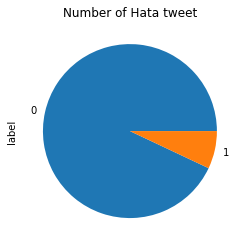

In [14]:
train['label'].value_counts().plot(kind='pie')
plt.title('Number of Hata tweet');

In [15]:
xtrain = train['tweet']

In [16]:
y=train['label']

ERROR: Could not install packages due to an EnvironmentError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\catboost\\_catboost.pyd'
Consider using the `--user` option or check the permissions.



  Using cached shap-0.39.0-cp38-cp38-win_amd64.whl (414 kB)
  Using cached graphviz-0.16-py2.py3-none-any.whl (19 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11434 sha256=a3f4cd4c3a23884a8017a1c8c8bc2427ff281b44840ac3a8a4537b0e4fa14a44
  Stored in directory: c:\users\uk15\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


# Text Data Preprocessing

In [17]:
xcorpus=[]
for i in range(0, len(xtrain)):
    review = re.sub('[^a-zA-Z]',' ', xtrain[i])  # replaces all the special charater
    review = review.lower()                      # converting everything to normal
    review = nltk.word_tokenize(review)                      # splitig
    
    review = [wnl.lemmatize(word) for word in review if not word in stopwords.words('english')] # removing Stop words
    review = ' '.join(review)                       # combining the words
    xcorpus.append(review)

In [18]:
len(xcorpus)

31962

In [19]:
xcorpus[1]

'user user thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked'

__Creating TF*IDF sparse matrix.__

In [20]:
tfid.fit(xcorpus)

TfidfVectorizer(max_features=15000)

In [21]:
X=tfid.transform(xcorpus)

In [22]:
X

<31962x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 224562 stored elements in Compressed Sparse Row format>

In [23]:
X.shape

(31962, 15000)

In [24]:
xtrain,xvalid,ytrain,yvalid = train_test_split(X,y,test_size=.3 ,random_state=42)

__RandomOverSampler to handle imbalanced data__

In [25]:

xtrain_res, ytrain_res = os.fit_sample(xtrain, ytrain)

In [19]:
xtrain_res.shape

((41630, 15000),
 1    20815
 0    20815
 Name: label, dtype: int64)

<AxesSubplot:ylabel='label'>

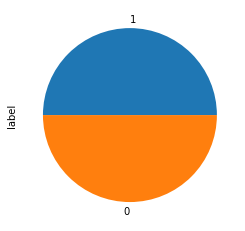

In [27]:
ytrain_res.value_counts().plot(kind='pie')

In [24]:
xtrain_res.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
ytrain_res=list(ytrain_res)

### Hyperparameter tuning.

In [157]:

lr=LogisticRegression()
penalty = ['l1', 'l2']
C = [ 0.01, 0.1, 1, 10]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=lr,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(xtrain_res, ytrain_res)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  7.6min finished


Best Score:  0.995341659007272
Best Params:  {'C': 10, 'class_weight': {1: 0.5, 0: 0.5}, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
clf = RandomForestClassifier()
param_grid = {'n_estimators':[200,300,400], 'max_depth':[20,30,None], 'criterion':['gini','entropy']}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=5, scoring=make_scorer(f1_score))
cv_res = grid.fit(xtrain_res, ytrain_res)
print(cv_res.cv_results_)
print(cv_res.best_params_)



# Model building and testing

In [22]:
algos = [LogisticRegression(C=10, class_weight= {1: 0.5, 0: 0.5}, penalty= 'l2', solver= 'saga'),  RandomForestClassifier(),DecisionTreeClassifier(criterion = 'gini',max_depth=20),MultinomialNB()]
names = ['LogisticRegression','RandomForestClassifier','DTC','Naive Bayes']

pred= []
for name in algos:
    model = name
    model.fit(xtrain_res, ytrain_res)
    y_pred = model.predict(xvalid)
    print(name)
    print(confusion_matrix(yvalid,y_pred))
    print(classification_report(yvalid,y_pred))
    pred.append(y_pred)

LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, solver='saga')
[[8626  279]
 [ 205  479]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8905
           1       0.63      0.70      0.66       684

    accuracy                           0.95      9589
   macro avg       0.80      0.83      0.82      9589
weighted avg       0.95      0.95      0.95      9589

RandomForestClassifier()
[[8800  105]
 [ 311  373]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8905
           1       0.78      0.55      0.64       684

    accuracy                           0.96      9589
   macro avg       0.87      0.77      0.81      9589
weighted avg       0.95      0.96      0.95      9589

DecisionTreeClassifier(max_depth=20)
[[6679 2226]
 [ 193  491]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      8905
           1       0.18

In [24]:
y_pred=pd.DataFrame({'LR':pred[0],'RFC':pred[1],'DTC':pred[2],'NB':pred[3]})

In [25]:
result=y_pred.mode(axis=1)[0]
result

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9584    0.0
9585    0.0
9586    0.0
9587    1.0
9588    0.0
Name: 0, Length: 9589, dtype: float64

In [26]:
print(confusion_matrix(yvalid,result))
print(classification_report(yvalid,result))

[[8738  167]
 [ 247  437]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8905
           1       0.72      0.64      0.68       684

    accuracy                           0.96      9589
   macro avg       0.85      0.81      0.83      9589
weighted avg       0.95      0.96      0.96      9589



# Test Data Preprocessing

In [27]:
test=pd.read_csv('test_tweets_anuFYb8.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [28]:
test.isna().sum()

id       0
tweet    0
dtype: int64

In [29]:
test.drop('id',axis=1,inplace=True)

In [30]:
xtest=test['tweet']

In [31]:
corpus=[]
for i in range(0,len(xtest)):
    sentence=re.sub('[^a-zA-Z]',' ',xtest[i])
    sentence=sentence.lower()
    sentence=nltk.word_tokenize(sentence)
    
    sentence=[wnl.lemmatize(word) for word in sentence if not word in stopwords.words('english')]
    sentence=' '.join(sentence)
    corpus.append(sentence)

In [32]:
corpus[1]

'user white supremacist want everyone see new bird movie'

In [33]:
Xtest=tfid.transform(corpus).toarray()

In [34]:
Xtest.shape

(17197, 15000)

In [35]:
os =  RandomOverSampler()
xtrain_res, ytrain_res = os.fit_sample(X, y)

# Final Stacking Model

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
algos = [LogisticRegression(C=10, class_weight= {1: 0.5, 0: 0.5}, penalty= 'l2', solver= 'saga'),  RandomForestClassifier(),DecisionTreeClassifier(criterion = 'gini',max_depth=20),MultinomialNB()]
names = ['LogisticRegression','RandomForestClassifier','DTC','Naive Bayes']

pred= []
for name in algos:
    model = name
    model.fit(xtrain_res, ytrain_res)
    y_pred = model.predict(Xtest)
    pred.append(y_pred)

In [38]:
y_pred=pd.DataFrame({'LR':pred[0],'RFC':pred[1],'DTC':pred[2],'NB':pred[3]})

In [39]:
result=y_pred.mode(axis=1)[0]

In [40]:
submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = result
submission.to_csv('result.csv', index=False)